## Use stacked images (3D) and Vit model

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
    
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 64


## Functions to load images

In [3]:
def load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 256, 256, 64)
0.0 1.0 0.07902179328632788 0.00023671822699371212


In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(12)

## train / test splits

In [5]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_df["MGMT_value"],
)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [6]:
df_train.tail()

,BraTS21ID,MGMT_value
105,157,0
222,322,1
114,170,0
223,324,0
81,123,0


## Model and training classes

In [7]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", rotate=rotation)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [8]:
!pip install ../input/einops-030/einops-0.3.0-py2.py3-none-any.whl

Processing /kaggle/input/einops-030/einops-0.3.0-py2.py3-none-any.whl


In [9]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        mlp_dim = 2048
        for _ in range(depth):
            #print (dim, mlp_dim)
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


### Vit Model change to 3D

reference:
https://github.com/lucidrains/vit-pytorch

In [10]:
class Model(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) *(image_size // patch_size)* 2
        patch_dim = channels * patch_size ** 3

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        #print (mlp_dim)
        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
        #print (dim)
        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, num_classes),
            nn.Dropout(dropout)
        )

    def forward(self, img, mask = None):
        p = self.patch_size
        #print (img.shape)
        x = rearrange(img, 'b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1 = p, p2 = p, p3 = p)
        #print (x.shape)
        x = self.patch_to_embedding(x)
        #print (x.shape)
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        #print (cls_tokens.shape)
        x = torch.cat((cls_tokens, x), dim=1)
        #print (x.shape)
        #print (self.pos_embedding.shape)
        x += self.pos_embedding
        x = self.dropout(x)

        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [11]:

class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            #if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()

            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(torch.sigmoid(outputs).tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-best.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)


## train models

In [12]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=True
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=4,
        shuffle=True,
        num_workers=8,pin_memory = True
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=4,
        shuffle=False,
        num_workers=8,pin_memory = True
    )

    model = Model(
        image_size = 256,
        patch_size = 32,
        num_classes = 1,
        dim = 1024,
        depth = 2,
        heads = 16,
        mlp_dim = 2048,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
    )
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        15, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        15,
    )
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)


(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
446,645,0,FLAIR
529,777,1,FLAIR
420,607,1,FLAIR
406,589,0,FLAIR
475,690,1,FLAIR


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.8639, time: 90.00 s            
[Epoch Valid: 1] loss: 0.6915, auc: 0.6200, time: 21.00 s
auc improved from inf to 0.6915. Saved model to 'FLAIR-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.6983, time: 71.00 s            
[Epoch Valid: 2] loss: 0.6918, auc: 0.6309, time: 17.00 s
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.6932, time: 71.00 s            
[Epoch Valid: 3] loss: 0.6879, auc: 0.6206, time: 17.00 s
auc improved from 0.6915 to 0.6879. Saved model to 'FLAIR-best.pth'
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.6936, time: 71.00 s            
[Epoch Valid: 4] loss: 0.6907, auc: 0.5992, time: 17.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.9016, time: 71.00 s            
[Epoch Valid: 5] loss: 0.7021, auc: 0.5334, time: 16.00 s
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.7287, time: 71.00 s            
[Epoch Valid: 6] loss: 0.7011, auc: 0.5626, time: 16.00 s
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.6979, time: 71.00 s            
[Epoch Valid: 7] loss: 0.6929, auc: 0.6022, time: 16.00 s
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.6941, time: 70.00 s            
[Epoch Valid: 8] loss: 0.6933, auc: 0.5533, time: 16.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.6939, time: 72.00 s            
[Epoch Valid: 9] loss: 0.6931, auc: 0.5331, time: 16.00 s
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.6929, time: 72.00 s            
[Epoch Valid: 10] loss: 0.6927, auc: 0.5751, time: 16.00 s
EPOCH: 11


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 11] loss: 0.6938, time: 71.00 s            
[Epoch Valid: 11] loss: 0.6928, auc: 0.5779, time: 16.00 s
EPOCH: 12


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 12] loss: 0.6937, time: 71.00 s            
[Epoch Valid: 12] loss: 0.6926, auc: 0.5770, time: 16.00 s
EPOCH: 13


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 13] loss: 0.7029, time: 72.00 s            
[Epoch Valid: 13] loss: 0.6969, auc: 0.6355, time: 16.00 s
EPOCH: 14


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 14] loss: 0.6952, time: 71.00 s            
[Epoch Valid: 14] loss: 0.6931, auc: 0.5758, time: 17.00 s
EPOCH: 15


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 15] loss: 0.6998, time: 72.00 s            
[Epoch Valid: 15] loss: 0.6930, auc: 0.6210, time: 16.00 s
(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
446,645,0,T1w
529,777,1,T1w
420,607,1,T1w
406,589,0,T1w
475,690,1,T1w


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.7953, time: 76.00 s            
[Epoch Valid: 1] loss: 0.6949, auc: 0.5695, time: 19.00 s
auc improved from inf to 0.6949. Saved model to 'T1w-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.7048, time: 68.00 s            
[Epoch Valid: 2] loss: 0.6937, auc: 0.5580, time: 17.00 s
auc improved from 0.6949 to 0.6937. Saved model to 'T1w-best.pth'
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.6958, time: 67.00 s            
[Epoch Valid: 3] loss: 0.6918, auc: 0.5691, time: 15.00 s
auc improved from 0.6937 to 0.6918. Saved model to 'T1w-best.pth'
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.6928, time: 64.00 s            
[Epoch Valid: 4] loss: 0.6920, auc: 0.5714, time: 15.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.7004, time: 63.00 s            
[Epoch Valid: 5] loss: 0.7047, auc: 0.5828, time: 15.00 s
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.6965, time: 64.00 s            
[Epoch Valid: 6] loss: 0.6913, auc: 0.5779, time: 15.00 s
auc improved from 0.6918 to 0.6913. Saved model to 'T1w-best.pth'
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.6936, time: 63.00 s            
[Epoch Valid: 7] loss: 0.6992, auc: 0.5129, time: 14.00 s
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.6937, time: 64.00 s            
[Epoch Valid: 8] loss: 0.6920, auc: 0.5972, time: 14.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.6963, time: 62.00 s            
[Epoch Valid: 9] loss: 0.7143, auc: 0.5987, time: 15.00 s
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.6965, time: 63.00 s            
[Epoch Valid: 10] loss: 0.6910, auc: 0.5946, time: 14.00 s
auc improved from 0.6913 to 0.6910. Saved model to 'T1w-best.pth'
EPOCH: 11


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 11] loss: 0.6991, time: 63.00 s            
[Epoch Valid: 11] loss: 0.6925, auc: 0.6203, time: 14.00 s
EPOCH: 12


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 12] loss: 0.6967, time: 62.00 s            
[Epoch Valid: 12] loss: 0.7610, auc: 0.4016, time: 14.00 s
EPOCH: 13


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 13] loss: 0.6974, time: 62.00 s            
[Epoch Valid: 13] loss: 0.6891, auc: 0.6150, time: 15.00 s
auc improved from 0.6910 to 0.6891. Saved model to 'T1w-best.pth'
EPOCH: 14


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 14] loss: 0.6925, time: 63.00 s            
[Epoch Valid: 14] loss: 0.6910, auc: 0.5884, time: 14.00 s
EPOCH: 15


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 15] loss: 0.6926, time: 63.00 s            
[Epoch Valid: 15] loss: 0.6922, auc: 0.6028, time: 15.00 s
(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
446,645,0,T1wCE
529,777,1,T1wCE
420,607,1,T1wCE
406,589,0,T1wCE
475,690,1,T1wCE


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.8005, time: 84.00 s            
[Epoch Valid: 1] loss: 0.6927, auc: 0.5984, time: 20.00 s
auc improved from inf to 0.6927. Saved model to 'T1wCE-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.7027, time: 72.00 s            
[Epoch Valid: 2] loss: 0.6839, auc: 0.6237, time: 16.00 s
auc improved from 0.6927 to 0.6839. Saved model to 'T1wCE-best.pth'
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.6960, time: 72.00 s            
[Epoch Valid: 3] loss: 0.7031, auc: 0.5943, time: 15.00 s
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.6991, time: 70.00 s            
[Epoch Valid: 4] loss: 0.6892, auc: 0.6030, time: 16.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.6952, time: 69.00 s            
[Epoch Valid: 5] loss: 0.6868, auc: 0.5843, time: 16.00 s
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.6951, time: 69.00 s            
[Epoch Valid: 6] loss: 0.6901, auc: 0.5951, time: 16.00 s
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.6967, time: 69.00 s            
[Epoch Valid: 7] loss: 0.6894, auc: 0.5928, time: 16.00 s
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.6929, time: 69.00 s            
[Epoch Valid: 8] loss: 0.6877, auc: 0.6048, time: 16.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.6927, time: 69.00 s            
[Epoch Valid: 9] loss: 0.6865, auc: 0.6010, time: 16.00 s
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.7103, time: 69.00 s            
[Epoch Valid: 10] loss: 0.6981, auc: 0.4164, time: 16.00 s
EPOCH: 11


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 11] loss: 0.6957, time: 69.00 s            
[Epoch Valid: 11] loss: 0.6924, auc: 0.5448, time: 16.00 s
EPOCH: 12


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 12] loss: 0.6948, time: 68.00 s            
[Epoch Valid: 12] loss: 0.6937, auc: 0.5662, time: 16.00 s
EPOCH: 13


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 13] loss: 0.6923, time: 69.00 s            
[Epoch Valid: 13] loss: 0.6895, auc: 0.5749, time: 16.00 s
EPOCH: 14


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 14] loss: 0.6934, time: 69.00 s            
[Epoch Valid: 14] loss: 0.6922, auc: 0.5682, time: 15.00 s
EPOCH: 15


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 15] loss: 0.6946, time: 68.00 s            
[Epoch Valid: 15] loss: 0.6899, auc: 0.5723, time: 16.00 s
(468, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
446,645,0,T2w
529,777,1,T2w
420,607,1,T2w
406,589,0,T2w
475,690,1,T2w


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


EPOCH: 1
[Epoch Train: 1] loss: 0.7880, time: 93.00 s            
[Epoch Valid: 1] loss: 0.6933, auc: 0.5840, time: 22.00 s
auc improved from inf to 0.6933. Saved model to 'T2w-best.pth'
EPOCH: 2


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 2] loss: 0.6967, time: 87.00 s            
[Epoch Valid: 2] loss: 0.6904, auc: 0.5837, time: 20.00 s
auc improved from 0.6933 to 0.6904. Saved model to 'T2w-best.pth'
EPOCH: 3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 3] loss: 0.7010, time: 80.00 s            
[Epoch Valid: 3] loss: 0.6920, auc: 0.5849, time: 20.00 s
EPOCH: 4


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 4] loss: 0.6934, time: 75.00 s            
[Epoch Valid: 4] loss: 0.6911, auc: 0.5786, time: 17.00 s
EPOCH: 5


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 5] loss: 0.7112, time: 75.00 s            
[Epoch Valid: 5] loss: 0.6921, auc: 0.5686, time: 17.00 s
EPOCH: 6


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 6] loss: 0.6993, time: 76.00 s            
[Epoch Valid: 6] loss: 0.6929, auc: 0.5726, time: 17.00 s
EPOCH: 7


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 7] loss: 0.6975, time: 73.00 s            
[Epoch Valid: 7] loss: 0.6987, auc: 0.5732, time: 17.00 s
EPOCH: 8


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 8] loss: 0.6950, time: 76.00 s            
[Epoch Valid: 8] loss: 0.6926, auc: 0.5662, time: 16.00 s
EPOCH: 9


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 9] loss: 0.6964, time: 73.00 s            
[Epoch Valid: 9] loss: 0.6919, auc: 0.5878, time: 16.00 s
EPOCH: 10


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 10] loss: 0.7039, time: 75.00 s            
[Epoch Valid: 10] loss: 0.6922, auc: 0.5706, time: 17.00 s
EPOCH: 11


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 11] loss: 0.6920, time: 73.00 s            
[Epoch Valid: 11] loss: 0.7112, auc: 0.4227, time: 17.00 s
EPOCH: 12


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 12] loss: 0.6950, time: 74.00 s            
[Epoch Valid: 12] loss: 0.6924, auc: 0.5960, time: 17.00 s
EPOCH: 13


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 13] loss: 0.6932, time: 73.00 s            
[Epoch Valid: 13] loss: 0.6924, auc: 0.5970, time: 16.00 s
EPOCH: 14


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 14] loss: 0.6982, time: 75.00 s            
[Epoch Valid: 14] loss: 0.7006, auc: 0.5907, time: 16.00 s
EPOCH: 15


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch Train: 15] loss: 0.7072, time: 77.00 s            
[Epoch Valid: 15] loss: 0.6928, auc: 0.6130, time: 17.00 s
['FLAIR-best.pth', 'T1w-best.pth', 'T1wCE-best.pth', 'T2w-best.pth']


## Predict function

In [13]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model(
        image_size = 256,
        patch_size = 32,
        num_classes = 1,
        dim = 1024,
        depth = 2,
        heads = 16,
        mlp_dim = 2048,
        channels = 1,
        dropout = 0.1,
        emb_dropout = 0.1
    )
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

In [14]:
from IPython.display import FileLink
FileLink(r'T1w-best.pth')
FileLink(r'T2w-best.pth')
FileLink(r'T1wCE-best.pth')
FileLink(r'FLAIR-best.pth')

/kaggle/working/FLAIR-best.pth

## Ensemble for validation

In [15]:
import xgboost as xgb
df_train = df_train.set_index("BraTS21ID")


df_train["FLAIR"] = 0
df_train["T1w"] = 0
df_train["T1wCE"] = 0
df_train["T2w"] = 0
df_train["MGMT_pred"] = 0

modelfiles = ["/kaggle/input/vit-epocs-15/T1wCE-best.pth","/kaggle/input/vit-epocs-15/T2w-best.pth","/kaggle/input/vit-epocs-15/FLAIR-best.pth","/kaggle/input/vit-epocs-15/T1w-best.pth"]
mri_types = ["T1wCE","T2w","FLAIR","T1w"]

for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_train, mtype, "train")
    df_train[mtype] = pred["MGMT_value"]
df_train




Predict: /kaggle/input/vit-epocs-15/T1wCE-best.pth T1wCE (468, 7)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predict: /kaggle/input/vit-epocs-15/T2w-best.pth T2w (468, 7)
Predict: /kaggle/input/vit-epocs-15/FLAIR-best.pth FLAIR (468, 7)
Predict: /kaggle/input/vit-epocs-15/T1w-best.pth T1w (468, 7)


,MGMT_value,MRI_Type,FLAIR,T1w,T1wCE,T2w,MGMT_pred
BraTS21ID,,,,,,,
645,0,T1w,0.513984,0.517244,0.518541,0.507177,0
777,1,T1w,0.509904,0.516882,0.522056,0.507054,0
607,1,T1w,0.508506,0.514823,0.518395,0.507094,0
589,0,T1w,0.484034,0.499213,0.447417,0.485581,0
690,1,T1w,0.513696,0.518201,0.522413,0.507059,0
...,...,...,...,...,...,...,...
157,0,T1w,0.513767,0.503505,0.474066,0.489073,0
322,1,T1w,0.487679,0.500835,0.484243,0.489287,0
170,0,T1w,0.512727,0.500103,0.466686,0.487031,0


In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


base_learner = DecisionTreeClassifier(max_depth=1)


boosted_model = AdaBoostClassifier(base_estimator=base_learner, n_estimators=4)


boosted_model.fit(df_train[mri_types], df_train["MGMT_value"])

ensemble_predictions = boosted_model.predict_proba(df_train[mri_types])[:,1]



print(f'Ensemble Accuracy: {ensemble_predictions}')

Ensemble Accuracy: [0.52255049 0.52255049 0.52255049 0.48057225 0.52255049 0.56823487
 0.52255049 0.48057225 0.52255049 0.52255049 0.52255049 0.52255049
 0.52489266 0.48057225 0.56823487 0.52255049 0.48057225 0.48057225
 0.52255049 0.52255049 0.56823487 0.48057225 0.52255049 0.52255049
 0.48057225 0.48057225 0.52255049 0.56823487 0.52255049 0.52255049
 0.48057225 0.52255049 0.48057225 0.56823487 0.52255049 0.48057225
 0.48057225 0.52255049 0.52489266 0.4593421  0.52255049 0.52255049
 0.52255049 0.4593421  0.48057225 0.48057225 0.52489266 0.52255049
 0.52255049 0.52255049 0.52255049 0.52255049 0.52255049 0.48057225
 0.48057225 0.52255049 0.52255049 0.48057225 0.48057225 0.56823487
 0.52255049 0.52255049 0.52255049 0.52255049 0.52255049 0.56823487
 0.52255049 0.48057225 0.48057225 0.48057225 0.52255049 0.48057225
 0.52255049 0.52255049 0.48057225 0.52255049 0.48057225 0.48057225
 0.48057225 0.56823487 0.48057225 0.52255049 0.52489266 0.52255049
 0.48057225 0.56823487 0.52489266 0.5225504

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Predict: /kaggle/input/vit-epocs-15/T1wCE-best.pth T1wCE (117, 7)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predict: /kaggle/input/vit-epocs-15/T2w-best.pth T2w (117, 7)
Predict: /kaggle/input/vit-epocs-15/FLAIR-best.pth FLAIR (117, 7)
Predict: /kaggle/input/vit-epocs-15/T1w-best.pth T1w (117, 7)
Validation ensemble AUC: 0.5613


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


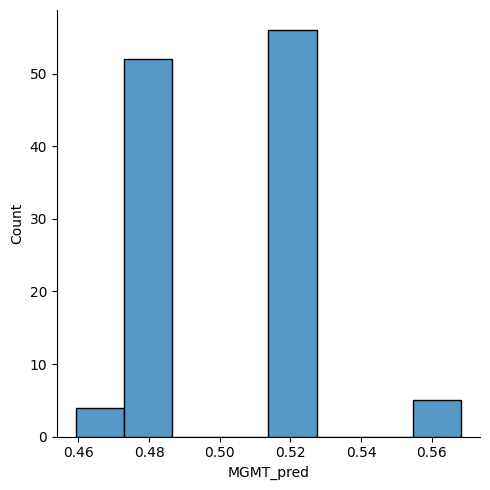

In [17]:
df_valid = df_valid.set_index("BraTS21ID")
df_valid["FLAIR"] = 0
df_valid["T1w"] = 0
df_valid["T1wCE"] = 0
df_valid["T2w"] = 0
df_valid["MGMT_pred"] = 0

for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid[mtype] = pred["MGMT_value"]
df_valid["MGMT_pred"] = boosted_model.predict_proba(df_valid[mri_types])[:,1]
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])

## Ensemble for submission

In [18]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv", index_col="BraTS21ID")
submission["FLAIR"] = 0
submission["T1w"] = 0
submission["T1wCE"] = 0
submission["T2w"] = 0

submission["MGMT_value"] = 0
for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, submission, mtype, split="test")
    submission[mtype] = pred["MGMT_value"]
submission["MGMT_value"] = boosted_model.predict_proba(submission[mri_types])[:,1]

submission["MGMT_value"].to_csv("submission.csv")

Predict: /kaggle/input/vit-epocs-15/T1wCE-best.pth T1wCE (87, 5)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predict: /kaggle/input/vit-epocs-15/T2w-best.pth T2w (87, 6)
Predict: /kaggle/input/vit-epocs-15/FLAIR-best.pth FLAIR (87, 6)
Predict: /kaggle/input/vit-epocs-15/T1w-best.pth T1w (87, 6)


In [19]:
submission

,MGMT_value,FLAIR,T1w,T1wCE,T2w,MRI_Type
BraTS21ID,,,,,,
1,0.480572,0.511039,0.507638,0.518801,0.506880,T1w
13,0.522550,0.514016,0.516039,0.518801,0.507159,T1w
15,0.522550,0.513839,0.518631,0.518025,0.507046,T1w
27,0.568235,0.511589,0.519966,0.521178,0.506979,T1w
37,0.522550,0.512096,0.519107,0.501645,0.507073,T1w
...,...,...,...,...,...,...
826,0.480572,0.489216,0.499787,0.464380,0.502250,T1w
829,0.480572,0.511188,0.500790,0.508221,0.506918,T1w
833,0.480572,0.487473,0.498842,0.471598,0.498738,T1w


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


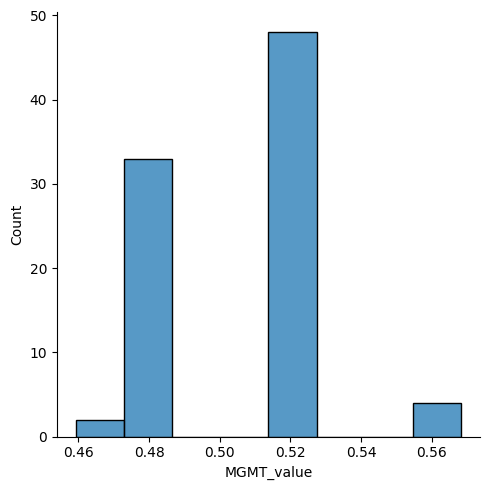

In [20]:
sns.displot(submission["MGMT_value"])